In [475]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from advertorch.attacks import GradientSignAttack, CarliniWagnerL2Attack, PGDAttack

# makes default tensor a CUDA tensor so GPU can be used
torch.set_default_tensor_type('torch.cuda.FloatTensor')

### Define data loaders and data preprocessing steps

In [476]:
data_preprocess = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))])
# the mean of mnist pixel data is .1307 and the stddev is .3081

train_loader = torch.utils.data.DataLoader(
                    torchvision.datasets.MNIST('./data', train=True, download=True,
                         transform=data_preprocess), 
                    batch_size=64, 
                    shuffle=True)

test_loader = torch.utils.data.DataLoader(
                    torchvision.datasets.MNIST('./data', train=False, download=True,
                         transform=data_preprocess), 
                    batch_size=1000, 
                    shuffle=True)

### Define the model

In [477]:
class LeNet(nn.Module):
    """MNIST-modified LeNet-5 model.
    """
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc1_drop = nn.Dropout(p=.50)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_drop = nn.Dropout(p=.50)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = self.fc1_drop(F.relu(self.fc1(x)))
        x = self.fc2_drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

### Define adversarial example generation function

In [478]:
def generate_adversarial_samples(og_samples, true_labels, adversary, num_per_samp=1):
    """Create num_per_samp adversarial examples for each sample in
    og_samples. Return the generated samples along with corresponding 
    adv_labels, a tensor containing the adversarial examples' labels.
    """
    adv_samples = []
    for i in range(num_per_samp):
        adv_samples.append(adversary.perturb(og_samples, true_labels))
    adv_samples = torch.cat(adv_samples, 0)
    adv_labels = torch.cat([true_labels]*num_per_samp, 0)
    return adv_samples, adv_labels

### Define my loss function for weighting adversarial examples


In [479]:
def my_loss(output, labels, l2_reg=False, alpha1=.005, jac_reg=False, alpha2=.005, x=None):
    """Adds terms for L2-regularization and the norm of the input-output 
    Jacobian to the standard cross-entropy loss function. Check https://arxiv.org/abs/1908.02729
    for alpha1, alpha2 suggestions.
    """
    # standard cross-entropy loss base
    loss = F.cross_entropy(output, labels)
    
    # add l2 regularization to loss 
    if l2_reg:
        l2 = 0
        for p in lenet.parameters():
            l2 += p.pow(2).sum()
        loss = loss + alpha1*l2
    
    # add input-output jacobian regularization to loss 
    if jac_reg:
        n_classes = output.shape[1]
        j = torch.zeros(output.shape[0], n_classes, x.shape[1], x.shape[2], x.shape[3])
        for i in range(n_classes):
            # for each training example we have the gradient of each output class w.r.t each 
            # input pixel, so shape is (1,10,1,28,28). For each batch, it's (64,10,1,28,28)
            j[:, i] = torch.autograd.grad(output[:, i].sum(), x, retain_graph=True)[0].data
        j = j.view(output.shape[0], -1)
        j = torch.mean(j, dim=0, keepdim=True)
        j = torch.norm(j, dim=1)
        loss = loss + alpha2*j

    return loss

### Define train and test functions 

In [480]:
def train(epoch, adversary=None):
    lenet.train()
    
    for batch_idx, (samples, labels) in enumerate(train_loader):
        # send inputs and labels to GPU
        samples, labels = samples.to(device), labels.to(device)
        
        # expand dataset with adversarial examples if adversary specified
        if adversary != None:
            adv_samples, adv_labels = generate_adversarial_samples(samples, labels, adversary)  
            samples, labels = torch.cat([samples, adv_samples], 0), torch.cat([labels, adv_labels], 0)
            samples, labels = samples.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # needed so that we can get gradient of output w.r.t input
        samples = Variable(samples, requires_grad=True)
        
        output = lenet(samples)
        loss = my_loss(output, labels, jac_reg=True, alpha2=.005, x=samples)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} \tLoss: {loss.item():.6f}')
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))    

In [481]:
def test():
    lenet.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for samples, labels in test_loader:
            samples, labels = samples.to(device), labels.to(device)
            output = lenet(samples)

            # negative log-likelihood loss
            test_loss += my_loss(output, labels).item()
            # output is a tensor, .data retrieves its data, max must return the index of the highest valued element
            preds = output.data.max(1, keepdim=True)[1]
            correct += preds.eq(labels.data.view_as(preds)).sum().item()
                
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * float(correct / len(test_loader.dataset))
    
    print(f'Test set: \n\tAvg. loss: {test_loss:.6f}\n\tAccuracy: ({test_accuracy:.2f}%)')
    
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

### Training

In [ ]:
# instantiate model and optimizer
lenet = LeNet()
lenet.cuda()
optimizer = optim.SGD(lenet.parameters(), lr=learning_rate, momentum=momentum)

device = 0

# define adversaries to train against
FGSM = GradientSignAttack(lenet, loss_fn=F.cross_entropy, eps=.3, clip_min=-3, clip_max=3, targeted=False)
PGD = PGDAttack(lenet, loss_fn=F.cross_entropy, eps=.3, 
                nb_iter=40, eps_iter=0.01, rand_init=True, 
                clip_min=-3, clip_max=3, targeted=False)
CW = CarliniWagnerL2Attack(confidence=0,
                targeted=False, learning_rate=0.01,
                binary_search_steps=9, max_iterations=10000,
                abort_early=True, initial_const=1e-3,
                clip_min=-3, clip_max=3, loss_fn=None):)

# training details
torch.manual_seed(1)

n_epochs = 15
learning_rate = 0.01
momentum = 0.9
log_interval = 150

# lists for tracking training progress
train_losses = []
train_counter = []
test_accuracies = []
test_losses = []
    
for epoch in range(1, n_epochs + 1):
    train(epoch)#adversary=FGSM)
    test()

### View performance 

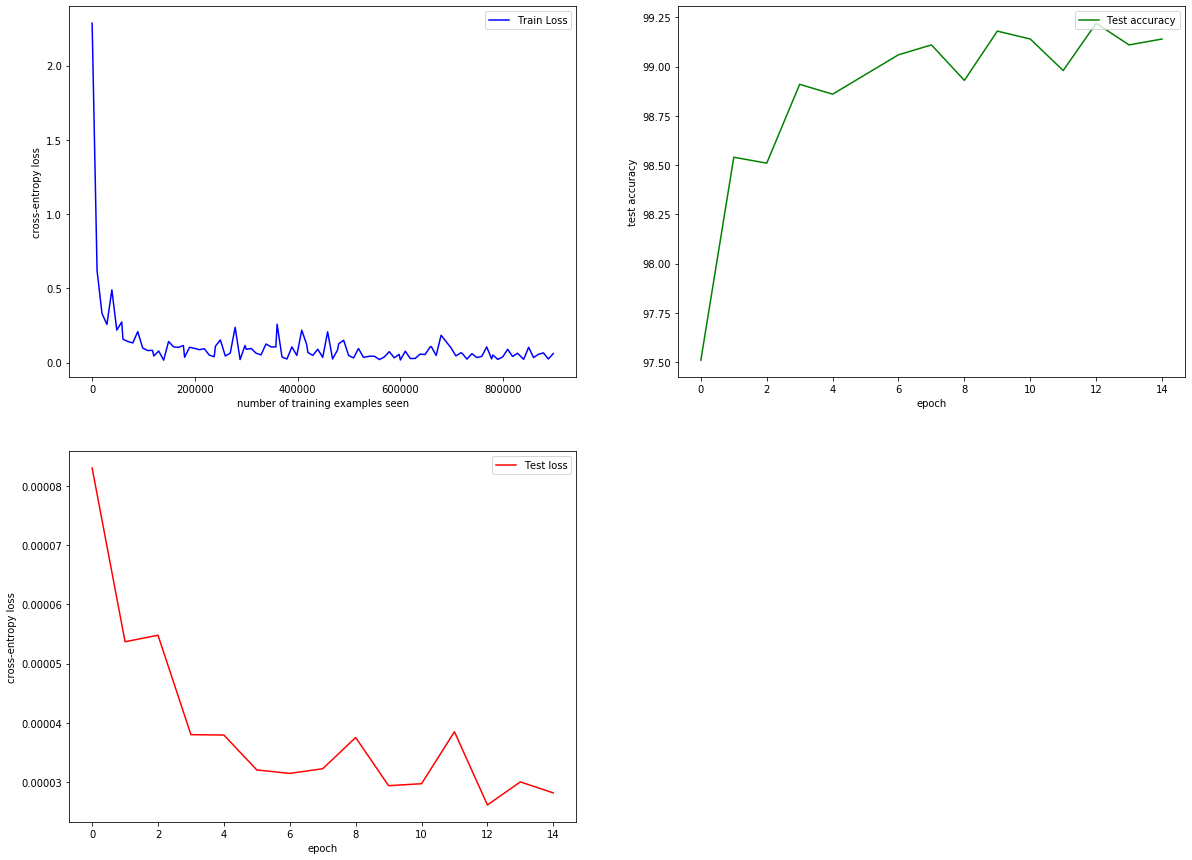

In [485]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(2,2,1)
ax1.plot(train_counter, train_losses, color='blue')
ax1.legend(['Train Loss'], loc='upper right')
ax1.set_xlabel('number of training examples seen')
ax1.set_ylabel('cross-entropy loss')

ax2 = fig.add_subplot(2,2,2)
ax2.plot(list(range(n_epochs)), test_accuracies, 'green')
ax2.legend(['Test accuracy'], loc='upper right')
ax2.set_xlabel('epoch')
ax2.set_ylabel('test accuracy')

ax3 = fig.add_subplot(2,2,3)
ax3.plot(list(range(n_epochs)), test_losses, 'red')
ax3.legend(['Test loss'], loc='upper right')
ax3.set_xlabel('epoch')
ax3.set_ylabel('cross-entropy loss')

plt.show()